# Driver Drowsiness Detection System

### MediaPipe

In [39]:
# import the necessary libraries
import time
import cv2
import mediapipe as mp
import multiprocessing
from math import hypot
from playsound import playsound


class Project:
    def __init__(self):     # Constructor
        self.p = multiprocessing.Process()

    def soundOn(self):      # Play Sound
        if not self.p.is_alive():
            self.p = multiprocessing.Process(target=playsound, args=("alarm.mp3",))
            self.p.start()

    def soundOff(self):     # Stop Sound
        if self.p.is_alive():
            self.p.terminate()

    def aspect_ratio(self, landmark_list, face_landmarks):   # Calculate Aspect Ratio
        n = len(landmark_list)

        # Calculate horizontal length
        left_point = face_landmarks[landmark_list[0]] # (x, y)
        right_point = face_landmarks[landmark_list[n//2]]
        hor_length = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))

        top = list()    # Co-ordinates of the upper part    
        bottom = list() # Co-ordinates of the lower part

        for i in range(1, n//2):
            top.append(face_landmarks[landmark_list[i]])
            bottom.append(face_landmarks[landmark_list[-1*i]])

        ver_lengths = list()
        for i in range(len(top)):   # Calculate vertical lengths
            d = hypot((top[i][0] - bottom[i][0]), (top[i][1] - bottom[i][1]))
            ver_lengths.append(d)

        s = len(ver_lengths)
        ratio = sum(ver_lengths) / (s * hor_length) # Calculate aspect ratio
        return ratio

    def landmarkCoordinates(self, facelandmarks, image):
        coord = list()
        ih, iw, ic = image.shape # image height, image width, image channels
        for lm in facelandmarks:
            x, y = int(lm.x*iw), int(lm.y*ih)
            coord.append((x, y))
        return coord

    def drowsinessDetectionSystem(self, video_path = 0):
        cap = cv2.VideoCapture(video_path)
        pTime = 0

        mpFaceMesh = mp.solutions.face_mesh
        faceMesh = mpFaceMesh.FaceMesh()
        
        eye_close_count = 0
        mouth_open_count = 0
        font = cv2.FONT_HERSHEY_COMPLEX

        yawn_count = 0
        yawning = False
        drowsy_count = 0 
        drowsy = False

        max_ear = 0
        min_ear = 1
        per = 40
        threshold_ear = 0.25
        threshold_mar = 0.35
        max_frame_count = 20

        le = [33, 246, 161, 160, 159, 158, 157, 173,
            133, 155, 154, 153, 145, 144, 163, 7]
        re = [362, 398, 384, 385, 386, 387, 388, 466,
            263, 249, 390, 373, 374, 380, 381, 382]

        il = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
        ol = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 375, 321, 405, 314, 17, 84, 181, 91, 146]
        
        while True:
            success, frame = cap.read()
            if not success:     # If no frame is detected then stop
                break

            frame = cv2.flip(frame, 1)
            results = faceMesh.process(frame)  # Detect faces

            cTime = time.time()
            fps = 1/(cTime - pTime)
            pTime = cTime
            cv2.putText(frame, f"FPS: {int(fps)}", (10, 15), font, 0.5, (0,0,0))

            if results.multi_face_landmarks:
                face = results.multi_face_landmarks[0]     # Consider only 1st detected face
                face_landmarks = self.landmarkCoordinates(face.landmark, frame)   # Get facial landmarks

                left_eye_ratio = self.aspect_ratio(le, face_landmarks) # 7vertical 1horizontal
                right_eye_ratio = self.aspect_ratio(re, face_landmarks) # 7v 1h
                eye_aspect_ratio = (left_eye_ratio + right_eye_ratio) / 2   # Calculate eye aspect ratio
                cv2.putText(frame, "Cur EAR: "+str(round(eye_aspect_ratio, 5)), (10, 30), font, 0.5, (0, 0, 0))
                cv2.putText(frame, "Thresh EAR: "+str(round(threshold_ear, 5)), (10, 45), font, 0.5, (0, 0, 0))

                cv2.putText(frame, "Drowsy Count: "+str(drowsy_count), (250, 15), font, 0.5, (0, 0, 0))

                inner_lip_ratio = self.aspect_ratio(il, face_landmarks) # 9v  1h
                outter_lip_ratio = self.aspect_ratio(ol, face_landmarks) # 9v 1h
                mouth_aspect_ratio = (inner_lip_ratio + outter_lip_ratio) / 2 # Calculate mouth aspect ratio
                cv2.putText(frame, "Cur MAR: "+str(round(mouth_aspect_ratio, 5)), (475, 15), font, 0.5, (0, 0, 0))
                cv2.putText(frame, "Thresh MAR: "+str(round(threshold_mar, 5)), (475, 30), font, 0.5, (0, 0, 0))
                cv2.putText(frame, "Yawn Count: "+str(yawn_count), (475, 45), font, 0.5, (0, 0, 0))

                max_ear = max(max_ear, eye_aspect_ratio)
                min_ear = min(min_ear, eye_aspect_ratio)
                diff = max_ear - min_ear
                threshold_ear = min_ear + diff * per / 100      # Calculate threshold eye aspect ratio

                if eye_aspect_ratio < threshold_ear:
                    eye_close_count += 1
                else:
                    eye_close_count = 0

                if mouth_aspect_ratio > threshold_mar:
                    mouth_open_count += 1
                else:
                    mouth_open_count = 0

                if eye_close_count >= max_frame_count:
                    cv2.putText(frame, "Eyes Closed", (10, 70), font, 0.75, (0, 0, 255))
                if mouth_open_count >= max_frame_count:
                    cv2.putText(frame, "Yawning", (475, 70), font, 0.75, (0, 0, 255))
                    if not yawning:
                        yawn_count += 1
                        yawning = True
                else:
                    if yawning:
                        yawning = False

                # Get co-ordinates of rectangle in which face is detected
                x1, y1 = face_landmarks[234][0], face_landmarks[10][1]
                x2, y2 = face_landmarks[454][0], face_landmarks[152][1]

                if eye_close_count < max_frame_count and mouth_open_count < max_frame_count:
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (31, 163, 21), 2)
                    cv2.putText(frame, "Active :)", (250, 50), font, 1, (31, 163, 21))
                    self.soundOff()
                    if drowsy:
                        drowsy = False
                else:
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(frame, "Drowsy!", (250, 50), font, 1, (255, 0, 0))
                    self.soundOn()
                    if not drowsy:
                        drowsy_count += 1
                        drowsy = True

                for i in le + re + il + ol:  # Plot facial landmarks
                    (x, y) = (face_landmarks[i][0], face_landmarks[i][1])
                    cv2.circle(frame, (x, y), 1, (255, 255, 255), -1)

            else:
                self.soundOff()

            cv2.imshow("Driver Drowsiness Detection System", frame) # Display frame

            key = cv2.waitKey(20)    # Press Esc to exit
            if key == 27:
                break

        self.soundOff()
        cap.release()
        cv2.destroyAllWindows()

obj = Project()
video_path = (input("Enter path of video: ") or 0)
obj.drowsinessDetectionSystem(video_path)

### Annotate Video (Manual Method)

In [6]:
# import the necessary libraries
import cv2
import xlsxwriter

class AnnotDataset:

    def AnnotateDataset(self, video_path):
        cap = cv2.VideoCapture(video_path)

        n = video_path.split("\\")[-1]
        n = n.split(".")[0]
        workbook = xlsxwriter.Workbook("Testing Dataset\\Annotation\\" + n + ".xlsx")
        worksheet = workbook.add_worksheet()
        worksheet.write('A1', 'Frame Number')
        worksheet.write('B1', 'Drowsy Status')

        frame_count = 0
        font = cv2.FONT_HERSHEY_COMPLEX

        while True:
            ret, frame = cap.read()
            if not ret:     # If no frame is detected then stop
                break

            frame_count += 1
            frame = cv2.flip(frame, 1)

            key = cv2.waitKey(75) 
            if key == 27:   # Press Esc to exit
                break
            elif key == 100:    # Press d to enter drowsy state
                worksheet.write('B'+str(frame_count+1), 1)
                cv2.putText(frame, "Drowsy!", (250, 50), font, 1, (255, 0, 0))
            else:
                worksheet.write('B'+str(frame_count+1), 0)
                cv2.putText(frame, "Active :)", (250, 50), font, 1, (31, 163, 21))
            worksheet.write('A'+str(frame_count+1), frame_count)

            cv2.imshow("Annotate Dataset", frame) # Display frame

        cap.release()
        cv2.destroyAllWindows()
        workbook.close()

obj = AnnotDataset()
video_path = input("Enter path of video: ")
obj.AnnotateDataset(video_path)

### Annotate a video using Algorithm 

In [38]:
# import the necessary libraries
import mediapipe as mp
import cv2
import os
import xlsxwriter
from math import hypot


class AnnotVideoAlgo:

    def aspect_ratio(self, landmark_list, face_landmarks):   # Calculate Aspect Ratio
        n = len(landmark_list)

        # Calculate horizontal length
        left_point = face_landmarks[landmark_list[0]] # (x, y)
        right_point = face_landmarks[landmark_list[n//2]]
        hor_length = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))

        top = list()    # Co-ordinates of the upper part    
        bottom = list() # Co-ordinates of the lower part

        for i in range(1, n//2):
            top.append(face_landmarks[landmark_list[i]])
            bottom.append(face_landmarks[landmark_list[-1*i]])

        ver_lengths = list()
        for i in range(len(top)):   # Calculate vertical lengths
            d = hypot((top[i][0] - bottom[i][0]), (top[i][1] - bottom[i][1]))
            ver_lengths.append(d)

        s = len(ver_lengths)
        ratio = sum(ver_lengths) / (s * hor_length) # Calculate aspect ratio
        return ratio

    def landmarkCoordinates(self, facelandmarks, image):
        coord = list()
        ih, iw, ic = image.shape # image height, image width, image channels
        for lm in facelandmarks:
            x, y = int(lm.x*iw), int(lm.y*ih)
            coord.append((x, y))
        return coord
    
    def AnnotateVideoAlgo(self, vid_path):
        video = os.fsdecode(vid_path)
        cap = cv2.VideoCapture(vid_path)

        n = video.split(".")[0]
        n = n.replace('\\Videos\\', '\\Annotation\\')
        workbook = xlsxwriter.Workbook(n + ".xlsx")
        worksheet = workbook.add_worksheet()
        worksheet.write('A1', 'Frame Number')
        worksheet.write('B1', 'Drowsy Status')
        
        frame_count = 0

        mpFaceMesh = mp.solutions.face_mesh
        faceMesh = mpFaceMesh.FaceMesh()
        
        eye_close_count = 0
        mouth_open_count = 0
        font = cv2.FONT_HERSHEY_COMPLEX

        max_ear = 0
        min_ear = 1
        per = 40
        threshold_ear = 0.25
        threshold_mar = 0.35
        max_frame_count = 20

        le = [33, 246, 161, 160, 159, 158, 157, 173,
            133, 155, 154, 153, 145, 144, 163, 7]
        re = [362, 398, 384, 385, 386, 387, 388, 466,
            263, 249, 390, 373, 374, 380, 381, 382]

        il = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
        ol = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 375, 321, 405, 314, 17, 84, 181, 91, 146]
        
        while True:
            success, frame = cap.read()
            if not success:     # If no frame is detected then stop
                break
            if vid_path.split('.')[-1] == "mp4":
                frame = cv2.resize(frame, (1600, 900))
            frame_count += 1
            frame = cv2.flip(frame, 1)
            results = faceMesh.process(frame)  # Detect faces


            if results.multi_face_landmarks:
                face = results.multi_face_landmarks[0]     # Consider only 1st detected face
                face_landmarks = self.landmarkCoordinates(face.landmark, frame)   # Get facial landmarks

                left_eye_ratio = self.aspect_ratio(le, face_landmarks) # 7vertical 1horizontal
                right_eye_ratio = self.aspect_ratio(re, face_landmarks) # 7v 1h
                eye_aspect_ratio = (left_eye_ratio + right_eye_ratio) / 2   # Calculate eye aspect ratio

                inner_lip_ratio = self.aspect_ratio(il, face_landmarks) # 9v  1h
                outter_lip_ratio = self.aspect_ratio(ol, face_landmarks) # 9v 1h
                mouth_aspect_ratio = (inner_lip_ratio + outter_lip_ratio) / 2 # Calculate mouth aspect ratio

                max_ear = max(max_ear, eye_aspect_ratio)
                min_ear = min(min_ear, eye_aspect_ratio)
                diff = max_ear - min_ear
                threshold_ear = min_ear + diff * per / 100      # Calculate threshold eye aspect ratio

                if eye_aspect_ratio < threshold_ear:
                    eye_close_count += 1
                else:
                    eye_close_count = 0

                if mouth_aspect_ratio > threshold_mar:
                    mouth_open_count += 1
                else:
                    mouth_open_count = 0


                if eye_close_count < max_frame_count and mouth_open_count < max_frame_count:
                    worksheet.write('B'+str(frame_count+1), 0)
                    cv2.putText(frame, "Active :)", (250, 50), font, 1, (31, 163, 21))

                else:
                    worksheet.write('B'+str(frame_count+1), 1)
                    cv2.putText(frame, "Drowsy!", (250, 50), font, 1, (255, 0, 0))
            else:
                worksheet.write('B'+str(frame_count+1), 0)
                    
            worksheet.write('A'+str(frame_count+1), frame_count)
            cv2.imshow("Annotate Video Using Algorithm", frame) # Display frame

            key = cv2.waitKey(20)    # Press Esc to exit
            if key == 27:
                break

        cap.release()
        cv2.destroyAllWindows()
        workbook.close()

obj = AnnotVideoAlgo()
vid_path = input("Enter path of video: ")
obj.AnnotateVideoAlgo(vid_path)

### Annotate all videos from directory using Algorithm

In [ ]:
# import the necessary libraries
import mediapipe as mp
import cv2
import os
import xlsxwriter
from math import hypot


class AnnotVideoAlgo:

    def aspect_ratio(self, landmark_list, face_landmarks):   # Calculate Aspect Ratio
        n = len(landmark_list)

        # Calculate horizontal length
        left_point = face_landmarks[landmark_list[0]] # (x, y)
        right_point = face_landmarks[landmark_list[n//2]]
        hor_length = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))

        top = list()    # Co-ordinates of the upper part    
        bottom = list() # Co-ordinates of the lower part

        for i in range(1, n//2):
            top.append(face_landmarks[landmark_list[i]])
            bottom.append(face_landmarks[landmark_list[-1*i]])

        ver_lengths = list()
        for i in range(len(top)):   # Calculate vertical lengths
            d = hypot((top[i][0] - bottom[i][0]), (top[i][1] - bottom[i][1]))
            ver_lengths.append(d)

        s = len(ver_lengths)
        ratio = sum(ver_lengths) / (s * hor_length) # Calculate aspect ratio
        return ratio

    def landmarkCoordinates(self, facelandmarks, image):
        coord = list()
        ih, iw, ic = image.shape # image height, image width, image channels
        for lm in facelandmarks:
            x, y = int(lm.x*iw), int(lm.y*ih)
            coord.append((x, y))
        return coord
    
    def AnnotateVideoAlgo(self, videos_dir):
        for f1 in os.listdir(videos_dir):
            video = os.fsdecode(f1)
            cap = cv2.VideoCapture(videos_dir + "\\" + video)

            n = video.split(".")[0]
            workbook = xlsxwriter.Workbook("Testing Dataset\\Annotation\\" + n + ".xlsx")
            worksheet = workbook.add_worksheet()
            worksheet.write('A1', 'Frame Number')
            worksheet.write('B1', 'Drowsy Status')
            
            frame_count = 0

            mpFaceMesh = mp.solutions.face_mesh
            faceMesh = mpFaceMesh.FaceMesh()
            
            eye_close_count = 0
            mouth_open_count = 0
            font = cv2.FONT_HERSHEY_COMPLEX

            max_ear = 0
            min_ear = 1
            per = 40
            threshold_ear = 0.25
            threshold_mar = 0.35
            max_frame_count = 20

            le = [33, 246, 161, 160, 159, 158, 157, 173,
                133, 155, 154, 153, 145, 144, 163, 7]
            re = [362, 398, 384, 385, 386, 387, 388, 466,
                263, 249, 390, 373, 374, 380, 381, 382]

            il = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
                308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
            ol = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
                291, 375, 321, 405, 314, 17, 84, 181, 91, 146]
            
            while True:
                success, frame = cap.read()
                if not success:     # If no frame is detected then stop
                    break
                if video_path.split('.')[-1] == "mp4":
                    frame = cv2.resize(frame, (1600, 900))
                frame_count += 1
                frame = cv2.flip(frame, 1)
                results = faceMesh.process(frame)  # Detect faces


                if results.multi_face_landmarks:
                    face = results.multi_face_landmarks[0]     # Consider only 1st detected face
                    face_landmarks = self.landmarkCoordinates(face.landmark, frame)   # Get facial landmarks

                    left_eye_ratio = self.aspect_ratio(le, face_landmarks) # 7vertical 1horizontal
                    right_eye_ratio = self.aspect_ratio(re, face_landmarks) # 7v 1h
                    eye_aspect_ratio = (left_eye_ratio + right_eye_ratio) / 2   # Calculate eye aspect ratio

                    inner_lip_ratio = self.aspect_ratio(il, face_landmarks) # 9v  1h
                    outter_lip_ratio = self.aspect_ratio(ol, face_landmarks) # 9v 1h
                    mouth_aspect_ratio = (inner_lip_ratio + outter_lip_ratio) / 2 # Calculate mouth aspect ratio

                    max_ear = max(max_ear, eye_aspect_ratio)
                    min_ear = min(min_ear, eye_aspect_ratio)
                    diff = max_ear - min_ear
                    threshold_ear = min_ear + diff * per / 100      # Calculate threshold eye aspect ratio

                    if eye_aspect_ratio < threshold_ear:
                        eye_close_count += 1
                    else:
                        eye_close_count = 0

                    if mouth_aspect_ratio > threshold_mar:
                        mouth_open_count += 1
                    else:
                        mouth_open_count = 0


                    if eye_close_count < max_frame_count and mouth_open_count < max_frame_count:
                        worksheet.write('B'+str(frame_count+1), 0)
                        cv2.putText(frame, "Active :)", (250, 50), font, 1, (31, 163, 21))

                    else:
                        worksheet.write('B'+str(frame_count+1), 1)
                        cv2.putText(frame, "Drowsy!", (250, 50), font, 1, (255, 0, 0))
                else:
                    worksheet.write('B'+str(frame_count+1), 0)
                      
                worksheet.write('A'+str(frame_count+1), frame_count)
                cv2.imshow("Annotate Video Using Algorithm", frame) # Display frame

                key = cv2.waitKey(20)    # Press Esc to exit
                if key == 27:
                    break

            cap.release()
            cv2.destroyAllWindows()
            workbook.close()

obj = AnnotVideoAlgo()
video_dir = input("Enter path of videos directory: ")
obj.AnnotateVideoAlgo(video_dir)

### Create combined result file to calculate accuracy

In [36]:
# import the necessary libraries
import mediapipe as mp
import cv2
import os
import pandas as pd
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from math import hypot

class Predict:
    
    def aspect_ratio(self, landmark_list, face_landmarks):   # Calculate Aspect Ratio
        n = len(landmark_list)

        # Calculate horizontal length
        left_point = face_landmarks[landmark_list[0]] # (x, y)
        right_point = face_landmarks[landmark_list[n//2]]
        hor_length = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))

        top = list()    # Co-ordinates of the upper part    
        bottom = list() # Co-ordinates of the lower part

        for i in range(1, n//2):
            top.append(face_landmarks[landmark_list[i]])
            bottom.append(face_landmarks[landmark_list[-1*i]])

        ver_lengths = list()
        for i in range(len(top)):   # Calculate vertical lengths
            d = hypot((top[i][0] - bottom[i][0]), (top[i][1] - bottom[i][1]))
            ver_lengths.append(d)

        s = len(ver_lengths)
        ratio = sum(ver_lengths) / (s * hor_length) # Calculate aspect ratio
        return ratio

    def landmarkCoordinates(self, facelandmarks, image):
        coord = list()
        ih, iw, ic = image.shape # image height, image width, image channels
        for lm in facelandmarks:
            x, y = int(lm.x*iw), int(lm.y*ih)
            coord.append((x, y))
        return coord

    def pred(self, dir1, dir2):

        data_present = pd.read_excel("Testing Dataset\\Results.xlsx")["Video"].unique()

        for (f1, f2) in zip(os.listdir(dir1), os.listdir(dir2)):
            file_name = os.fsdecode(f1)
            annot_name = os.fsdecode(f2)

            if file_name in data_present:
                print("Data for video", file_name, "is already present.")
                continue

            if file_name.split('.')[0] == annot_name.split('.')[0]: 
                video_path = os.path.join(dir1, file_name)
                annot_path = os.path.join(dir2, annot_name)

                cap = cv2.VideoCapture(video_path)
                frame_count = 0

                mpFaceMesh = mp.solutions.face_mesh
                faceMesh = mpFaceMesh.FaceMesh()
                    
                eye_close_count = 0
                mouth_open_count = 0
                font = cv2.FONT_HERSHEY_COMPLEX

                yawn_count = 0
                yawning = False
                drowsy_count = 0 
                drowsy = False

                max_ear = 0
                min_ear = 1
                per = 40
                threshold_ear = 0.25
                threshold_mar = 0.35
                max_frame_count = 20

                le = [33, 246, 161, 160, 159, 158, 157, 173,
                    133, 155, 154, 153, 145, 144, 163, 7]
                re = [362, 398, 384, 385, 386, 387, 388, 466,
                    263, 249, 390, 373, 374, 380, 381, 382]

                il = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
                    308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
                ol = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
                    291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

                df = pd.read_excel(annot_path)
                actual = df["Drowsy Status"].to_list()
                predicted = list()

                while True:
                    success, frame = cap.read()
                    if not success:     # If no frame is detected then stop
                        break
                    if video_path.split('.')[-1] == "mp4":
                        frame = cv2.resize(frame, (1600, 900))
                    frame_count += 1
                    frame = cv2.flip(frame, 1)
                    results = faceMesh.process(frame)  # Detect faces


                    if results.multi_face_landmarks:
                        face = results.multi_face_landmarks[0]     # Consider only 1st detected face
                        face_landmarks = self.landmarkCoordinates(face.landmark, frame)   # Get facial landmarks

                        left_eye_ratio = self.aspect_ratio(le, face_landmarks) # 7vertical 1horizontal
                        right_eye_ratio = self.aspect_ratio(re, face_landmarks) # 7v 1h
                        eye_aspect_ratio = (left_eye_ratio + right_eye_ratio) / 2   # Calculate eye aspect ratio

                        inner_lip_ratio = self.aspect_ratio(il, face_landmarks) # 9v  1h
                        outter_lip_ratio = self.aspect_ratio(ol, face_landmarks) # 9v 1h
                        mouth_aspect_ratio = (inner_lip_ratio + outter_lip_ratio) / 2 # Calculate mouth aspect ratio

                        max_ear = max(max_ear, eye_aspect_ratio)
                        min_ear = min(min_ear, eye_aspect_ratio)
                        diff = max_ear - min_ear
                        threshold_ear = min_ear + diff * per / 100      # Calculate threshold eye aspect ratio

                        if eye_aspect_ratio < threshold_ear:
                            eye_close_count += 1
                        else:
                            eye_close_count = 0

                        if mouth_aspect_ratio > threshold_mar:
                            mouth_open_count += 1
                        else:
                            mouth_open_count = 0


                        if eye_close_count < max_frame_count and mouth_open_count < max_frame_count:
                            predicted.append(0)
                        else:
                            predicted.append(1)
                            
                    else:
                        predicted.append(0)

                    cv2.imshow("Create combined result file to calculate accuracy", frame) # Display frame

                    key = cv2.waitKey(20)    # Press Esc to exit
                    if key == 27:
                        break

                cap.release()
                cv2.destroyAllWindows()

                if len(actual) == len(predicted):
                    df2 = pd.DataFrame({"Video": file_name, "Frame Number": list(range(1, frame_count+1)), "Actual": actual, "Predicted": predicted})
                    workbook = openpyxl.load_workbook('Testing Dataset\Results.xlsx')
                    worksheet = workbook['Sheet1']
                    data = df2.values.tolist()
                    for row in data:
                        worksheet.append(row)
                    workbook.save('Testing Dataset\Results.xlsx')
                else:
                    print("Error in video", file_name)
            else:
                print("Error in video", file_name)

obj = Predict()
obj.pred("Testing Dataset\\Videos\\", "Testing Dataset\\Annotation\\")

Data for video FemaleNoGlasses.avi is already present.
Data for video P1043124_720.mp4 is already present.


### Testing Performace of Model using One Video

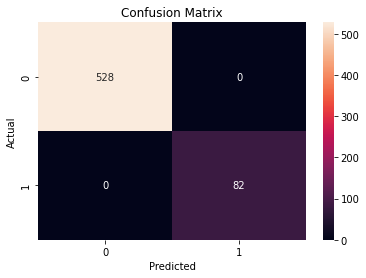

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [40]:
# import the necessary libraries
import mediapipe as mp
import cv2
import pandas as pd
import seaborn as sns
from math import hypot
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


class Test:

    def aspect_ratio(self, landmark_list, face_landmarks):   # Calculate Aspect Ratio
        n = len(landmark_list)

        # Calculate horizontal length
        left_point = face_landmarks[landmark_list[0]] # (x, y)
        right_point = face_landmarks[landmark_list[n//2]]
        hor_length = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))

        top = list()    # Co-ordinates of the upper part    
        bottom = list() # Co-ordinates of the lower part

        for i in range(1, n//2):
            top.append(face_landmarks[landmark_list[i]])
            bottom.append(face_landmarks[landmark_list[-1*i]])

        ver_lengths = list()
        for i in range(len(top)):   # Calculate vertical lengths
            d = hypot((top[i][0] - bottom[i][0]), (top[i][1] - bottom[i][1]))
            ver_lengths.append(d)

        s = len(ver_lengths)
        ratio = sum(ver_lengths) / (s * hor_length) # Calculate aspect ratio
        return ratio

    def landmarkCoordinates(self, facelandmarks, image):
        coord = list()
        ih, iw, ic = image.shape # image height, image width, image channels
        for lm in facelandmarks:
            x, y = int(lm.x*iw), int(lm.y*ih)
            coord.append((x, y))
        return coord

    def testing(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        mpFaceMesh = mp.solutions.face_mesh
        faceMesh = mpFaceMesh.FaceMesh()
            
        eye_close_count = 0
        mouth_open_count = 0
        font = cv2.FONT_HERSHEY_COMPLEX

        yawn_count = 0
        yawning = False
        drowsy_count = 0 
        drowsy = False

        max_ear = 0
        min_ear = 1
        per = 40
        threshold_ear = 0.25
        threshold_mar = 0.35
        max_frame_count = 20

        le = [33, 246, 161, 160, 159, 158, 157, 173,
            133, 155, 154, 153, 145, 144, 163, 7]
        re = [362, 398, 384, 385, 386, 387, 388, 466,
            263, 249, 390, 373, 374, 380, 381, 382]

        il = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
        ol = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

        n = video_path.split("\\")[-1]
        n = n.split(".")[0]
        df = pd.read_excel("Testing Dataset\\Annotation\\" + n + ".xlsx")
        actual = df["Drowsy Status"].to_list()
        predicted = list()

        while True:
            success, frame = cap.read()
            if not success:     # If no frame is detected then stop
                break
            if video_path.split('.')[-1] == "mp4":
                frame = cv2.resize(frame, (1600, 900))
            frame_count += 1
            frame = cv2.flip(frame, 1)
            results = faceMesh.process(frame)  # Detect faces


            if results.multi_face_landmarks:
                face = results.multi_face_landmarks[0]     # Consider only 1st detected face
                face_landmarks = self.landmarkCoordinates(face.landmark, frame)   # Get facial landmarks

                left_eye_ratio = self.aspect_ratio(le, face_landmarks) # 7vertical 1horizontal
                right_eye_ratio = self.aspect_ratio(re, face_landmarks) # 7v 1h
                eye_aspect_ratio = (left_eye_ratio + right_eye_ratio) / 2   # Calculate eye aspect ratio

                inner_lip_ratio = self.aspect_ratio(il, face_landmarks) # 9v  1h
                outter_lip_ratio = self.aspect_ratio(ol, face_landmarks) # 9v 1h
                mouth_aspect_ratio = (inner_lip_ratio + outter_lip_ratio) / 2 # Calculate mouth aspect ratio

                max_ear = max(max_ear, eye_aspect_ratio)
                min_ear = min(min_ear, eye_aspect_ratio)
                diff = max_ear - min_ear
                threshold_ear = min_ear + diff * per / 100      # Calculate threshold eye aspect ratio

                if eye_aspect_ratio < threshold_ear:
                    eye_close_count += 1
                else:
                    eye_close_count = 0

                if mouth_aspect_ratio > threshold_mar:
                    mouth_open_count += 1
                else:
                    mouth_open_count = 0


                if eye_close_count < max_frame_count and mouth_open_count < max_frame_count:
                    predicted.append(0)
                    cv2.putText(frame, "Predicted State => Active :)", (400, 50), font, 0.5, (31, 163, 21))
                else:
                    predicted.append(1)
                    cv2.putText(frame, "Predicted State => Drowsy!", (400, 50), font, 0.5, (255, 0, 0))
                    
                if actual[len(predicted)-1] == 1:
                    cv2.putText(frame, "Actual State => Drowsy!", (10, 50), font, 0.5, (255, 0, 0))
                else:
                    cv2.putText(frame, "Actual State=> Active :)", (10, 50), font, 0.5, (31, 163, 21))
                    
            else:
                predicted.append(0)

            cv2.imshow("Testing Performace of Model using One Video", frame) # Display frame

            key = cv2.waitKey(20)    # Press Esc to exit
            if key == 27:
                break

        cap.release()
        cv2.destroyAllWindows()

        if len(actual) != len(predicted):
            print("Error in", video_path.split("\\")[-1])
            return

        cm = confusion_matrix(actual, predicted)
        plt.figure()
        plt.title("Confusion Matrix")
        sns.heatmap(cm, annot=True, fmt="d")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Accuracy Score = (TP + TN) / (TP + FN + TN + FP)
        print('Accuracy:', round(accuracy_score(actual, predicted), 5))

        # Precision Score = TP / (FP + TP)
        print('Precision:', round(precision_score(actual, predicted), 5))

        # Recall Score = TP / (FN + TP)    
        print('Recall:', round(recall_score(actual, predicted), 5))

        # F1 Score = 2 * Precision Score * Recall Score / (Precision Score + Recall Score)
        print('F1 Score:', round(f1_score(actual, predicted), 5))

obj = Test()
video_path = input("Enter path of video: ")
obj.testing(video_path)

### Calculate Overall Accuracy of the Model

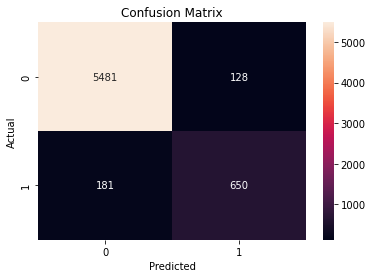

Accuracy: 0.95202
Precision: 0.83548
Recall: 0.78219
F1 Score: 0.80796


In [24]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

df = pd.read_excel("Testing Dataset\\Results.xlsx")
actual = df["Actual"].to_list()
predicted = df["Predicted"].to_list()

if len(actual) != len(predicted):
    print("Error in data")
    exit(0)

cm = confusion_matrix(actual, predicted)
plt.figure()
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy Score = (TP + TN) / (TP + FN + TN + FP)
print('Accuracy:', round(accuracy_score(actual, predicted), 5))

# Precision Score = TP / (FP + TP)
print('Precision:', round(precision_score(actual, predicted), 5))

# Recall Score = TP / (FN + TP)    
print('Recall:', round(recall_score(actual, predicted), 5))

# F1 Score = 2 * Precision Score * Recall Score / (Precision Score + Recall Score)
print('F1 Score:', round(f1_score(actual, predicted), 5))

### Delete data of a video from Results.xlsx

In [25]:
import pandas as pd

video = input("Enter name of video (with extension): ")
df = pd.read_excel("Testing Dataset\\Results.xlsx")
df = df[df["Video"] != video]

df.to_excel("Testing Dataset\\Results.xlsx", index = False)